## Max K Coloring Graph

The smaller K number of colors that can color a graph with the smaller Energy possible. The Energy being:
E = 1/2 * (Ws - Wd)
Where Ws is the sum of all the same color vertices edge, and the Wd is the sum of all the different ones.

In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

### Setup token to run the experiment on a real device
If you would like to run the experiement on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_accounts()` to store it first.

In [2]:
from qiskit import IBMQ
# IBMQ.load_accounts()

In [3]:
# Generating a graph of 4 nodes 

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0),(1,4,1.0),(4,0,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

In [4]:
W = G.get_edge_data(0, 1)

print(W)

{'weight': 1.0}


In [7]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0.]]


Greedy coloring with infinite K

{0: 0, 1: 1, 2: 2, 3: 1, 4: 2}


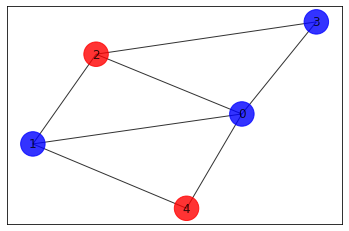

In [8]:
color_map = {}

for node in G.nodes:
    available_colors = [True] * (len(G.nodes))
    for neighbor in G.neighbors(node):
          if neighbor in color_map:
            color = color_map[neighbor]
            available_colors[color] = False
    for color, available in enumerate(available_colors):
          if available:
            color_map[node] = color
            break
print(color_map)


colors = ['r' if color_map[i] == 2 else 'b' for i in range(len(color_map))]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

### Mapping to the Ising problem

In [9]:
qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

In [12]:
from docplex.mp.model import Model
from qiskit.aqua.translators.ising import docplex
mdl = Model(name='min_K_func')

In [ ]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        w[i,j] = mdl.binary_var(name='x_{}{}'.format(i,j))
print(w)

In [30]:
# Object function
K = 3
min_K_func = mdl.sum((w[i,j] - 1)*(w[i,j] - 1) +  for i in range(n) for j in range(n))
mdl.minimize(min_K_func)

# No constraints for Max-Cut problems.

docplex.mp.LinearExpr(11)

In [38]:
qubitOp_docplex, offset_docplex = docplex.get_qubitops(mdl)

### Checking that the full Hamiltonian gives the right cost 

energy: -2.5
max-cut objective: -7.0
solution: [0. 0. 1. 0. 1.]
solution objective: 7.0


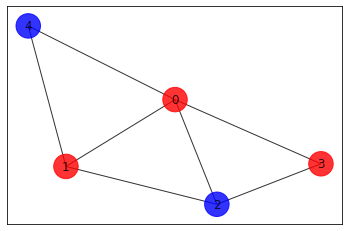

In [39]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

"""
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params,algo_input)
"""
x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

/Users/flaviajanine/.virtualenvs/qiskit_VQE/lib/python3.6/site-packages/qiskit/aqua/algorithms/adaptive/vqe/vqe.py:105: DeprecationWarning: operator_mode option is deprecated and it will be removed after 0.6. Now the operator has its own mode, no need extra info to tell the VQE.
  "Now the operator has its own mode, no need extra info to tell the VQE.", DeprecationWarning)


energy: -1.4998357282246
time: 23.997267246246338
max-cut objective: -5.9998357282246
solution: [1. 0. 0. 1. 1.]
solution objective: 6.0


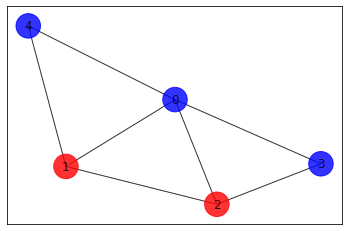

In [40]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, 'matrix')

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}
}

result = run_algorithm(params, algo_input)
"""

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

/Users/flaviajanine/.virtualenvs/qiskit_VQE/lib/python3.6/site-packages/qiskit/aqua/algorithms/adaptive/vqe/vqe.py:105: DeprecationWarning: operator_mode option is deprecated and it will be removed after 0.6. Now the operator has its own mode, no need extra info to tell the VQE.
  "Now the operator has its own mode, no need extra info to tell the VQE.", DeprecationWarning)


energy: -2.4501953125
time: 37.4135639667511
max-cut objective: -6.9501953125
solution: [1 1 0 1 0]
solution objective: 7.0


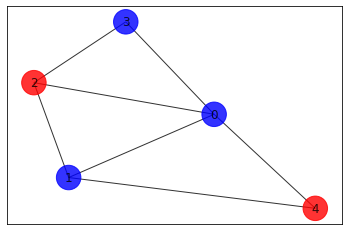

In [23]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, 'grouped_paulis')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach, update the param from the previous cell.
params['algorithm']['operator_mode'] = 'grouped_paulis'
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params, algo_input)
"""

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

### [Optional] Checking that the full Hamiltonian made by ```docplex.get_qubitops```  gives the right cost

energy: -2.5
max-cut objective: -7.0
solution: [0. 0. 1. 0. 1.]
solution objective: 7.0


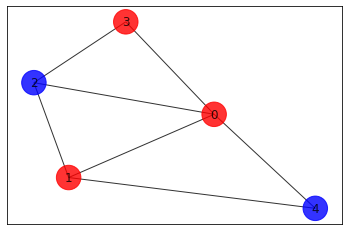

In [24]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp_docplex, k=1)
result = ee.run()

x = docplex.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset_docplex)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)